In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
import pandas as pd
import numpy as np
from utils.triangles_method import explainSamples
from utils.deepmatcher_utils import wrapDm

## Rnn model
We choose rnn model because it had strange rankings

In [4]:
rnn = dm.MatchingModel(attr_summarizer='rnn')
rnn.load_state('../../models/amz_google_rnn.pth')
rnn = rnn.to('cuda')

In [53]:
DATA_DIR = '../../datasets/Structured/Amazon-Google/'
test_df = pd.read_csv(DATA_DIR+'merged_test.csv')
amz = pd.read_csv(DATA_DIR+'tableA.csv',dtype=str)
google = pd.read_csv(DATA_DIR+'tableB.csv',dtype=str)

In [6]:
prediction = wrapDm(test_df,rnn,ignore_columns=['label'])
correct_preds = test_df[np.argmax(prediction,axis=1)==test_df.label.values]
len(test_df),len(correct_preds)

(2293, 2105)

In [7]:
neg_ranking4rnn,flippedneg4rnn = explainSamples(correct_preds,[amz,google],rnn,wrapDm,
                                       class_to_explain=0,maxLenAttributeSet=1)

100%|██████████| 338/338 [00:39<00:00,  8.57it/s]


In [8]:
pos_ranking4rnn,flippedpos4rnn = explainSamples(correct_preds,[amz,google],rnn,wrapDm,
                                       class_to_explain=1,maxLenAttributeSet=1)

100%|██████████| 338/338 [00:43<00:00,  7.77it/s]


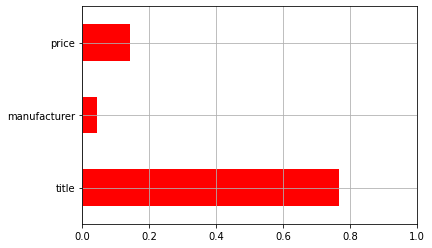

In [9]:
neg_ranking4rnn.plot.barh(color='red',grid=True,xlim=(0,1))

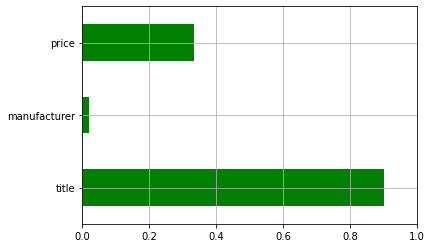

In [10]:
pos_ranking4rnn.plot.barh(color='green',grid=True,xlim=(0,1))

## Find patterns

In [9]:
from utils.patternDiscovery import getMaxFrequentPatterns

In [11]:
neg_patterns_onprice = getMaxFrequentPatterns(flippedneg4rnn[flippedneg4rnn.alteredAttributes==('price',)]
                                                             ,['ltable_price','rtable_price'],class_to_explain=1)
neg_patterns_onprice.head(10)

,support,itemsets


In [17]:
neg_patterns_ontitle = getMaxFrequentPatterns(flippedneg4rnn[flippedneg4rnn.alteredAttributes==('title',)]
                                                             ,['ltable_title','rtable_title'],class_to_explain=1,
                                                          min_support=0.15)
neg_patterns_ontitle.head(10)

,support,itemsets
0,0.154440,(L_()
1,0.162162,(L_software)


In [18]:
pos_patterns_ontitle = getMaxFrequentPatterns(flippedpos4rnn[flippedpos4rnn.alteredAttributes==('title',)]
                                                             ,['ltable_title','rtable_title'],class_to_explain=0,
                                             min_support=0.1)
pos_patterns_ontitle.head(10)

,support,itemsets
0,0.104918,"(L_instant, R_instant)"
1,0.121311,"(L_microsoft, R_microsoft)"
2,0.229508,"(R_adobe, R_cs3, L_adobe, L_cs3)"


In [ ]:
pos_patterns_onprice = getMaxFrequentPatterns(flippedpos4rnn[flippedpos4rnn.alteredAttributes==('price',)],
                                             ['ltable_price','rtable_price'])

In [54]:
positives = test_df[test_df.label==1]
prediction = wrapDm(positives,rnn,['label'])
np.count_nonzero(np.argmax(prediction,axis=1)==1)

137

In [55]:
positives = test_df[test_df.label==1].copy()
positives['ltable_title'] = positives['ltable_title'] +' adobe cs3 microsoft'
positives['rtable_title'] = positives['rtable_title'] + ' adobe cs3 microsoft'
np.count_nonzero(np.argmax(wrapDm(positives,rnn,['label']),axis=1))

121

In [31]:
negatives = test_df[test_df.label==0]
np.count_nonzero(np.argmax(wrapDm(negatives,rnn,['label']),axis=1)==0)

1976

In [32]:
negatives = negatives.copy()
negatives['ltable_title'] = negatives['ltable_title']+" software"
np.count_nonzero(np.argmax(wrapDm(negatives,rnn,['label']),axis=1)==0)

1979

## Build new samples

In [22]:
from utils.newSamplesBuilder import buildNewSamplesForAttribute

In [31]:
train_df = pd.read_csv('../../Structured/Amazon-Google/merged_train.csv')
len_negatives = train_df[train_df.label==0].shape[0]
len_positives = train_df[train_df.label==1].shape[0]
newSamplesForPrice = buildNewSamplesForAttribute(critical_pos_rnn,critical_neg_rnn,'price',int(len_positives/20),
                                                int(len_negatives/20))

In [33]:
newSamplesForPrice[newSamplesForPrice.label==1].shape,newSamplesForPrice[newSamplesForPrice.label==0].shape

((68, 7), (590, 7))

In [36]:
import numpy as np
newSamplesForPrice['id'] = np.arange(train_df.shape[0],train_df.shape[0]+newSamplesForPrice.shape[0])
extended_train = pd.concat([train_df,newSamplesForPrice])
extended_train.to_csv('temp/extended_train.csv',index=False)

In [38]:
!cp ../../Structured/Amazon-Google/merged_valid.csv temp
!cp ../../Structured/Amazon-Google/merged_test.csv temp

## Train model with new samples

In [39]:
train,validation,test = dm.data.process('temp',train='extended_train.csv',validation='merged_valid.csv',
                                       test='merged_test.csv',left_prefix='ltable_',right_prefix='rtable_')


Reading and processing data from "temp/extended_train.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "temp/merged_valid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "temp/merged_test.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [########] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [########] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [40]:
model = dm.MatchingModel(attr_summarizer='rnn')
model.run_train(train,validation,epochs=20,best_save_path='../../models/amazongoogle_rnn_extended.pth',pos_neg_ratio=8)

* Number of trainable parameters: 1762802
===>  TRAIN Epoch 1


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 1 || Run Time:    8.0 | Load Time:    4.2 || F1:  28.38 | Prec:  16.97 | Rec:  86.57 || Ex/s: 616.52

===>  EVAL Epoch 1


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 1 || Run Time:    0.7 | Load Time:    1.0 || F1:  40.13 | Prec:  26.60 | Rec:  81.62 || Ex/s: 1356.46

* Best F1: 40.12605042016807
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


Finished Epoch 2 || Run Time:    7.1 | Load Time:    4.2 || F1:  47.31 | Prec:  31.66 | Rec:  93.61 || Ex/s: 668.21

===>  EVAL Epoch 2


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 2 || Run Time:    0.7 | Load Time:    1.0 || F1:  51.30 | Prec:  38.82 | Rec:  75.64 || Ex/s: 1356.42

* Best F1: 51.30434782608695
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


Finished Epoch 3 || Run Time:    7.8 | Load Time:    4.2 || F1:  62.82 | Prec:  46.91 | Rec:  95.05 || Ex/s: 628.03

===>  EVAL Epoch 3


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 3 || Run Time:    0.7 | Load Time:    1.1 || F1:  57.93 | Prec:  48.55 | Rec:  71.79 || Ex/s: 1277.24

* Best F1: 57.93103448275862
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 4


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 4 || Run Time:    8.3 | Load Time:    4.3 || F1:  73.67 | Prec:  59.58 | Rec:  96.48 || Ex/s: 599.72

===>  EVAL Epoch 4


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 4 || Run Time:    0.7 | Load Time:    1.0 || F1:  61.34 | Prec:  54.28 | Rec:  70.51 || Ex/s: 1370.14

* Best F1: 61.33828996282528
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 5


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 5 || Run Time:    7.9 | Load Time:    4.3 || F1:  82.53 | Prec:  71.32 | Rec:  97.91 || Ex/s: 618.16

===>  EVAL Epoch 5


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 5 || Run Time:    0.7 | Load Time:    1.0 || F1:  62.26 | Prec:  57.14 | Rec:  68.38 || Ex/s: 1355.55

* Best F1: 62.2568093385214
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 6


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 6 || Run Time:    8.3 | Load Time:    4.3 || F1:  88.52 | Prec:  80.34 | Rec:  98.57 || Ex/s: 596.02

===>  EVAL Epoch 6


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 6 || Run Time:    0.7 | Load Time:    1.1 || F1:  61.93 | Prec:  57.51 | Rec:  67.09 || Ex/s: 1303.26

---------------------

===>  TRAIN Epoch 7


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 7 || Run Time:    7.8 | Load Time:    4.3 || F1:  91.24 | Prec:  84.54 | Rec:  99.09 || Ex/s: 622.56

===>  EVAL Epoch 7


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 7 || Run Time:    0.7 | Load Time:    1.1 || F1:  61.35 | Prec:  58.82 | Rec:  64.10 || Ex/s: 1317.06

---------------------

===>  TRAIN Epoch 8


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 8 || Run Time:    8.3 | Load Time:    4.2 || F1:  93.97 | Prec:  89.03 | Rec:  99.48 || Ex/s: 601.66

===>  EVAL Epoch 8


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 8 || Run Time:    0.7 | Load Time:    1.0 || F1:  61.03 | Prec:  58.96 | Rec:  63.25 || Ex/s: 1353.85

---------------------

===>  TRAIN Epoch 9


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


Finished Epoch 9 || Run Time:    7.7 | Load Time:    4.3 || F1:  95.44 | Prec:  91.61 | Rec:  99.61 || Ex/s: 625.72

===>  EVAL Epoch 9


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 9 || Run Time:    0.6 | Load Time:    1.0 || F1:  62.63 | Prec:  59.39 | Rec:  66.24 || Ex/s: 1379.56

* Best F1: 62.62626262626263
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 10


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 10 || Run Time:    8.2 | Load Time:    4.3 || F1:  96.34 | Prec:  93.28 | Rec:  99.61 || Ex/s: 603.68

===>  EVAL Epoch 10


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 10 || Run Time:    0.6 | Load Time:    1.0 || F1:  62.75 | Prec:  59.62 | Rec:  66.24 || Ex/s: 1379.93

* Best F1: 62.75303643724696
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 11


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


Finished Epoch 11 || Run Time:    7.6 | Load Time:    4.2 || F1:  96.95 | Prec:  94.44 | Rec:  99.61 || Ex/s: 637.40

===>  EVAL Epoch 11


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 11 || Run Time:    0.6 | Load Time:    1.0 || F1:  63.16 | Prec:  60.00 | Rec:  66.67 || Ex/s: 1373.76

* Best F1: 63.15789473684211
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 12


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 12 || Run Time:    8.0 | Load Time:    4.3 || F1:  97.45 | Prec:  95.38 | Rec:  99.61 || Ex/s: 615.07

===>  EVAL Epoch 12


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 12 || Run Time:    0.7 | Load Time:    1.0 || F1:  63.14 | Prec:  60.31 | Rec:  66.24 || Ex/s: 1355.02

---------------------

===>  TRAIN Epoch 13


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


Finished Epoch 13 || Run Time:    7.6 | Load Time:    4.2 || F1:  97.70 | Prec:  95.74 | Rec:  99.74 || Ex/s: 636.93

===>  EVAL Epoch 13


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 13 || Run Time:    0.6 | Load Time:    1.0 || F1:  63.14 | Prec:  60.31 | Rec:  66.24 || Ex/s: 1380.88

---------------------

===>  TRAIN Epoch 14


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


Finished Epoch 14 || Run Time:    7.5 | Load Time:    4.3 || F1:  97.70 | Prec:  95.74 | Rec:  99.74 || Ex/s: 637.65

===>  EVAL Epoch 14


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 14 || Run Time:    0.7 | Load Time:    1.1 || F1:  63.14 | Prec:  60.31 | Rec:  66.24 || Ex/s: 1326.36

---------------------

===>  TRAIN Epoch 15


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 15 || Run Time:    8.3 | Load Time:    4.3 || F1:  97.83 | Prec:  95.98 | Rec:  99.74 || Ex/s: 600.37

===>  EVAL Epoch 15


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 15 || Run Time:    0.6 | Load Time:    1.0 || F1:  62.86 | Prec:  60.16 | Rec:  65.81 || Ex/s: 1374.83

---------------------

===>  TRAIN Epoch 16


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 16 || Run Time:    7.9 | Load Time:    4.3 || F1:  97.89 | Prec:  96.11 | Rec:  99.74 || Ex/s: 619.48

===>  EVAL Epoch 16


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 16 || Run Time:    0.6 | Load Time:    1.0 || F1:  62.70 | Prec:  60.24 | Rec:  65.38 || Ex/s: 1377.06

---------------------

===>  TRAIN Epoch 17


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


Finished Epoch 17 || Run Time:    7.5 | Load Time:    4.2 || F1:  98.08 | Prec:  96.47 | Rec:  99.74 || Ex/s: 645.12

===>  EVAL Epoch 17


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 17 || Run Time:    0.7 | Load Time:    1.0 || F1:  62.83 | Prec:  60.47 | Rec:  65.38 || Ex/s: 1346.60

---------------------

===>  TRAIN Epoch 18


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 18 || Run Time:    7.9 | Load Time:    4.3 || F1:  98.08 | Prec:  96.47 | Rec:  99.74 || Ex/s: 621.04

===>  EVAL Epoch 18


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 18 || Run Time:    0.6 | Load Time:    1.0 || F1:  62.55 | Prec:  60.32 | Rec:  64.96 || Ex/s: 1374.01

---------------------

===>  TRAIN Epoch 19


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 19 || Run Time:    6.8 | Load Time:    4.1 || F1:  98.08 | Prec:  96.47 | Rec:  99.74 || Ex/s: 689.45

===>  EVAL Epoch 19


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 19 || Run Time:    0.6 | Load Time:    1.0 || F1:  62.27 | Prec:  60.16 | Rec:  64.53 || Ex/s: 1376.22

---------------------

===>  TRAIN Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 20 || Run Time:    8.1 | Load Time:    4.3 || F1:  98.08 | Prec:  96.47 | Rec:  99.74 || Ex/s: 608.17

===>  EVAL Epoch 20


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 20 || Run Time:    0.6 | Load Time:    1.0 || F1:  62.27 | Prec:  60.16 | Rec:  64.53 || Ex/s: 1388.06

---------------------

Loading best model...
Training done.


63.15789473684211

In [41]:
model.run_eval(test)

===>  EVAL Epoch 11


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 11 || Run Time:    0.7 | Load Time:    1.1 || F1:  64.07 | Prec:  61.66 | Rec:  66.67 || Ex/s: 1345.28



64.06570841889118

## New models evaluation

In [60]:
model = dm.MatchingModel(attr_summarizer='rnn')
model.load_state('../../models/amazongoogle_rnn_extended.pth')

## Recompute Ri

In [61]:
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi

In [62]:
testneg_classifier,testneg_ids = return_layer_input('../../Structured/Amazon-Google/'
                                                                         ,'test_negatives',128,model,
                                                                        model.classifier,device=-1)

In [63]:
testpos_classifier,testpos_ids = return_layer_input('../../Structured/Amazon-Google/',
                                                                  'test_positives',128,model,
                                                                  model.classifier,device=-1)

In [64]:
model = model.cuda()

In [65]:
classifier_len = len(testpos_classifier[0][0])
attribute_len = int(classifier_len/len(attributes))

In [66]:
positives_ri,pos_ri_norms = computeRi(model.classifier,
                                                    attributes,testpos_classifier,attribute_len,0)

100%|██████████| 128/128 [00:00<00:00, 128.78it/s]


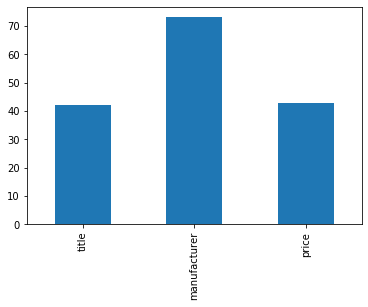

In [67]:
positives_variation_df = pd.DataFrame(data= pos_ri_norms,columns=attributes)
positives_variation_df.sum().plot.bar()

In [68]:
positives_variation_df.mean()

title           0.180291
manufacturer    0.312388
price           0.183280
dtype: float64

In [52]:
negatives_ri,neg_ri_norms = computeRi(model.classifier,
                                                    attributes,testneg_classifier,attribute_len,1)

100%|██████████| 128/128 [00:04<00:00, 28.09it/s]


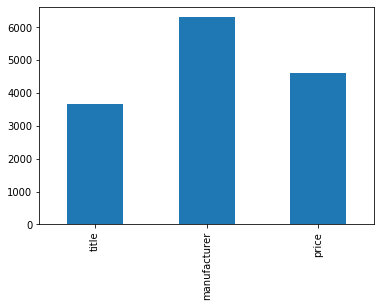

In [53]:
negatives_variation_df = pd.DataFrame(data= neg_ri_norms,columns=attributes)
negatives_variation_df.sum().plot.bar()

## Build new positives (10% more)

In [88]:
train_df = pd.read_csv('../../Structured/Amazon-Google/merged_train.csv')
len_negatives = train_df[train_df.label==0].shape[0]
len_positives = train_df[train_df.label==1].shape[0]
newSamplesForPrice = buildNewSamplesForAttribute(critical_pos_rnn,critical_neg_rnn,'price',int(len_positives/10),
                                                int(len_negatives/10))

In [89]:
newSamplesForPrice.shape

(728, 7)

In [90]:
newSamplesForPrice['id'] = np.arange(train_df.shape[0],train_df.shape[0]+newSamplesForPrice.shape[0])
extended_train = pd.concat([train_df,newSamplesForPrice])
extended_train.to_csv('temp/extended_train.csv',index=False)

In [91]:
extended_train.to_csv('temp/extended_train10perc.csv',index=False)

In [92]:
train,validation,test = dm.data.process('temp',train='extended_train10perc.csv',validation='merged_valid.csv',
                                       test='merged_test.csv',left_prefix='ltable_',right_prefix='rtable_')


Reading and processing data from "temp/extended_train10perc.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "temp/merged_valid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "temp/merged_test.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [########] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [########] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [94]:
model = dm.MatchingModel(attr_summarizer='rnn')
model.run_train(train,validation,epochs=20,best_save_path='../../models/amazongoogle_rnn_extended10perc.pth',
                pos_neg_ratio=10)

* Number of trainable parameters: 1762802
===>  TRAIN Epoch 1


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 1 || Run Time:    8.4 | Load Time:    4.3 || F1:  25.64 | Prec:  14.85 | Rec:  93.91 || Ex/s: 599.50

===>  EVAL Epoch 1


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 1 || Run Time:    0.7 | Load Time:    1.0 || F1:  23.07 | Prec:  13.06 | Rec:  99.15 || Ex/s: 1345.65

* Best F1: 23.07309796121333
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 2 || Run Time:    8.3 | Load Time:    4.3 || F1:  39.68 | Prec:  24.99 | Rec:  96.30 || Ex/s: 603.61

===>  EVAL Epoch 2


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 2 || Run Time:    0.7 | Load Time:    1.0 || F1:  35.29 | Prec:  21.75 | Rec:  93.59 || Ex/s: 1351.36

* Best F1: 35.294117647058826
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 3 || Run Time:    8.4 | Load Time:    4.3 || F1:  55.87 | Prec:  39.19 | Rec:  97.25 || Ex/s: 595.78

===>  EVAL Epoch 3


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 3 || Run Time:    0.7 | Load Time:    1.0 || F1:  47.81 | Prec:  33.06 | Rec:  86.32 || Ex/s: 1344.80

* Best F1: 47.81065088757396
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 4


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 4 || Run Time:    8.1 | Load Time:    4.3 || F1:  69.87 | Prec:  54.22 | Rec:  98.21 || Ex/s: 615.22

===>  EVAL Epoch 4


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 4 || Run Time:    0.7 | Load Time:    1.0 || F1:  56.78 | Prec:  45.00 | Rec:  76.92 || Ex/s: 1340.58

* Best F1: 56.782334384858046
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 5


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 5 || Run Time:    8.3 | Load Time:    4.3 || F1:  80.35 | Prec:  67.42 | Rec:  99.40 || Ex/s: 603.15

===>  EVAL Epoch 5


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 5 || Run Time:    0.7 | Load Time:    1.1 || F1:  57.65 | Prec:  49.39 | Rec:  69.23 || Ex/s: 1336.37

* Best F1: 57.65124555160142
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 6


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 6 || Run Time:    8.4 | Load Time:    4.3 || F1:  87.12 | Prec:  77.54 | Rec:  99.40 || Ex/s: 597.21

===>  EVAL Epoch 6


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 6 || Run Time:    0.7 | Load Time:    1.1 || F1:  57.25 | Prec:  49.69 | Rec:  67.52 || Ex/s: 1303.79

---------------------

===>  TRAIN Epoch 7


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 7 || Run Time:    8.2 | Load Time:    4.3 || F1:  91.79 | Prec:  85.17 | Rec:  99.52 || Ex/s: 608.03

===>  EVAL Epoch 7


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 7 || Run Time:    0.7 | Load Time:    1.0 || F1:  56.89 | Prec:  48.92 | Rec:  67.95 || Ex/s: 1338.70

---------------------

===>  TRAIN Epoch 8


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 8 || Run Time:    8.1 | Load Time:    4.3 || F1:  94.12 | Prec:  89.28 | Rec:  99.52 || Ex/s: 610.47

===>  EVAL Epoch 8


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 8 || Run Time:    0.7 | Load Time:    1.0 || F1:  58.61 | Prec:  51.28 | Rec:  68.38 || Ex/s: 1357.22

* Best F1: 58.60805860805861
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 9


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 9 || Run Time:    8.0 | Load Time:    4.4 || F1:  95.04 | Prec:  90.85 | Rec:  99.64 || Ex/s: 611.27

===>  EVAL Epoch 9


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 9 || Run Time:    0.7 | Load Time:    1.0 || F1:  59.26 | Prec:  52.29 | Rec:  68.38 || Ex/s: 1362.95

* Best F1: 59.25925925925926
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 10


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 10 || Run Time:    8.3 | Load Time:    4.4 || F1:  95.97 | Prec:  92.56 | Rec:  99.64 || Ex/s: 599.30

===>  EVAL Epoch 10


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 10 || Run Time:    0.6 | Load Time:    1.0 || F1:  59.44 | Prec:  52.82 | Rec:  67.95 || Ex/s: 1366.46

* Best F1: 59.43925233644859
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 11


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 11 || Run Time:    8.4 | Load Time:    4.4 || F1:  96.53 | Prec:  93.60 | Rec:  99.64 || Ex/s: 593.93

===>  EVAL Epoch 11


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 11 || Run Time:    0.6 | Load Time:    1.0 || F1:  59.47 | Prec:  53.40 | Rec:  67.09 || Ex/s: 1374.85

* Best F1: 59.469696969696976
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 12


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 12 || Run Time:    8.3 | Load Time:    4.3 || F1:  97.03 | Prec:  94.56 | Rec:  99.64 || Ex/s: 600.91

===>  EVAL Epoch 12


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 12 || Run Time:    0.7 | Load Time:    1.0 || F1:  59.77 | Prec:  54.17 | Rec:  66.67 || Ex/s: 1341.49

* Best F1: 59.770114942528735
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 13


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 13 || Run Time:    8.1 | Load Time:    4.4 || F1:  97.26 | Prec:  94.99 | Rec:  99.64 || Ex/s: 611.46

===>  EVAL Epoch 13


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 13 || Run Time:    0.7 | Load Time:    1.0 || F1:  59.96 | Prec:  54.77 | Rec:  66.24 || Ex/s: 1356.71

* Best F1: 59.96131528046421
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 14


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


Finished Epoch 14 || Run Time:    7.4 | Load Time:    4.3 || F1:  97.55 | Prec:  95.43 | Rec:  99.76 || Ex/s: 652.37

===>  EVAL Epoch 14


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 14 || Run Time:    0.7 | Load Time:    1.0 || F1:  60.31 | Prec:  55.36 | Rec:  66.24 || Ex/s: 1362.14

* Best F1: 60.31128404669261
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 15


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 15 || Run Time:    8.5 | Load Time:    4.4 || F1:  97.66 | Prec:  95.65 | Rec:  99.76 || Ex/s: 590.23

===>  EVAL Epoch 15


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 15 || Run Time:    0.7 | Load Time:    1.0 || F1:  59.96 | Prec:  55.68 | Rec:  64.96 || Ex/s: 1347.76

---------------------

===>  TRAIN Epoch 16


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 16 || Run Time:    8.1 | Load Time:    4.3 || F1:  97.72 | Prec:  95.76 | Rec:  99.76 || Ex/s: 611.21

===>  EVAL Epoch 16


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 16 || Run Time:    0.7 | Load Time:    1.0 || F1:  59.80 | Prec:  55.72 | Rec:  64.53 || Ex/s: 1329.04

---------------------

===>  TRAIN Epoch 17


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


Finished Epoch 17 || Run Time:    7.5 | Load Time:    4.4 || F1:  97.89 | Prec:  96.09 | Rec:  99.76 || Ex/s: 638.46

===>  EVAL Epoch 17


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 17 || Run Time:    0.7 | Load Time:    1.0 || F1:  59.76 | Prec:  55.97 | Rec:  64.10 || Ex/s: 1363.61

---------------------

===>  TRAIN Epoch 18


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 18 || Run Time:    8.4 | Load Time:    4.4 || F1:  97.95 | Prec:  96.20 | Rec:  99.76 || Ex/s: 595.06

===>  EVAL Epoch 18


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 18 || Run Time:    0.7 | Load Time:    1.0 || F1:  59.60 | Prec:  56.02 | Rec:  63.68 || Ex/s: 1354.49

---------------------

===>  TRAIN Epoch 19


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 19 || Run Time:    8.0 | Load Time:    4.3 || F1:  98.00 | Prec:  96.31 | Rec:  99.76 || Ex/s: 614.34

===>  EVAL Epoch 19


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 19 || Run Time:    0.7 | Load Time:    1.0 || F1:  59.44 | Prec:  56.06 | Rec:  63.25 || Ex/s: 1345.06

---------------------

===>  TRAIN Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 20 || Run Time:    8.0 | Load Time:    4.4 || F1:  98.06 | Prec:  96.31 | Rec:  99.88 || Ex/s: 613.60

===>  EVAL Epoch 20


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 20 || Run Time:    0.6 | Load Time:    1.0 || F1:  59.68 | Prec:  56.49 | Rec:  63.25 || Ex/s: 1366.22

---------------------

Loading best model...
Training done.


60.31128404669261

In [95]:
model = dm.MatchingModel(attr_summarizer='rnn')
model.load_state('../../models/amazongoogle_rnn_extended10perc.pth')

In [96]:
testpos_classifier,testpos_ids = return_layer_input('../../Structured/Amazon-Google/',
                                                                  'test_positives',128,model,
                                                                  model.classifier,device=-1)
testneg_classifier,testneg_ids = return_layer_input('../../Structured/Amazon-Google/'
                                                                         ,'test_negatives',128,model,
                                                                        model.classifier,device=-1)

In [97]:
model = model.cuda()

In [98]:
positives_ri,pos_ri_norms = computeRi(model.classifier,
                                                    attributes,testpos_classifier,attribute_len,0)

100%|██████████| 128/128 [00:01<00:00, 101.67it/s]


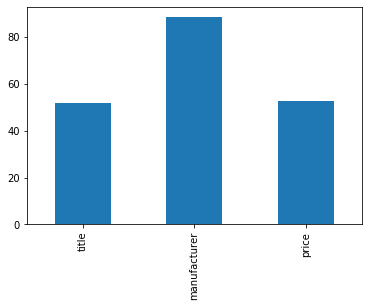

In [99]:
positives_variation_df = pd.DataFrame(data= pos_ri_norms,columns=attributes)
positives_variation_df.sum().plot.bar()